In [4]:
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import pandas as pd
import tqdm.notebook as tqdm
from multiprocessing import Pool
import seaborn as sns
import subprocess
import os
import pickle
import json 

import py.data_gen as data_gen
import py.algos as algos

plt.rcParams.update({'font.size': 18})

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
  
def save_runs(exp_root, exp_name, runs, args):
    git_hash = algos.get_git_revision_hash()
    dirty = b'script.py' in subprocess.check_output(['git', 'diff', '--name-only'])
    exp_root = os.path.join(exp_root, f'{git_hash}-dirty' if dirty else f'{git_hash}')
    exp_dir = os.path.join(exp_root, exp_name)
    os.makedirs(exp_dir)
    with open(os.path.join(exp_dir, 'results'), 'wb') as f:
        pickle.dump(runs, f)
    with open(os.path.join(exp_dir, 'args' ), 'w') as f:
        json.dump(vars(args), f, indent=True, sort_keys=True, cls=NumpyEncoder)

def get_accepted_per_round(_runs, n_rounds):
  _list1 = []
  for _r in _runs:
    accepted_per_round = np.array(np.array_split(_r, n_rounds)).sum(axis=-1)
    rejected_per_round = 1 - accepted_per_round
    _list1.append(accepted_per_round)
  accepted_per_round = np.concatenate(_list1)
  return accepted_per_round

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## harris et. al setup with selection

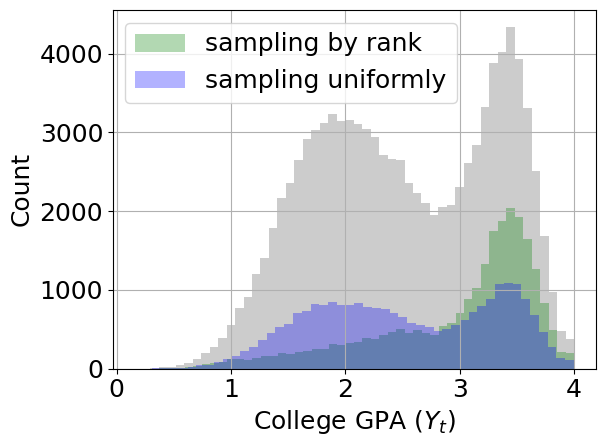

In [5]:
# plot data.
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --clip --envs-accept-rates .25 --rank-type uniform'
args = algos.get_args(cmd)
np.random.seed(1)
b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = data_gen.generate_data(
    args.num_applicants, args.applicants_per_round, args.fixed_effort_conversion, args
    )

cmd =f'--num-applicants 100000 --applicants-per-round 1000 --clip --envs-accept-rates .25 --rank-type prediction'
args = algos.get_args(cmd)
np.random.seed(1)
b,x,y2,EW,theta, w, z2, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = data_gen.generate_data(
    args.num_applicants, args.applicants_per_round, args.fixed_effort_conversion, args
    )
fig,ax=plt.subplots()
plt.hist(y2[0], alpha=.2 , color='k', bins=50)
plt.hist(y2[0][z2==1], color='g', bins=50, alpha=.3, label='sampling by rank')
plt.hist(y[0][z==1], color='b', bins=50, alpha=.3, label='sampling uniformly')
ax.grid()
ax.set_xlabel('College GPA ($Y_t$)')
ax.set_ylabel('Count')
ax.legend () 

# assert np.all (y2[0] ==y[0] )
plt.tight_layout()
plt.savefig('figures/haris-et-al-selection-dist.pdf')

In [6]:
n_runs = 50  
# ranking selection
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --clip --methods ols 2sls --envs-accept-rate .25 --rank-type prediction'
args = algos.get_args(cmd)
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(algos.run_multi_env, args_list )
runs = [r[0] for r in runs]

# uniform sampling
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --clip --methods ols 2sls --envs-accept-rate .25 --rank-type uniform'
args = algos.get_args(cmd)
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs2 = p.starmap(algos.run_multi_env, args_list )
runs2 = [r[0] for r in runs2]

99it [00:00, 100.10it/s]
99it [00:00, 102.13it/s]
99it [00:00, 107.91it/s]

99it [00:00, 99.42it/s]]
99it [00:00, 134.47it/s]
99it [00:00, 104.27it/s]

99it [00:01, 98.46it/s] 
99it [00:00, 107.90it/s]
99it [00:00, 105.29it/s]
99it [00:01, 93.17it/s]]

99it [00:01, 83.25it/s]
99it [00:01, 86.00it/s]
0it [00:00, ?it/s]4it/s]
95it [00:00, 94.62it/s] 
96it [00:00, 96.38it/s] 

99it [00:00, 117.27it/s]
99it [00:00, 106.41it/s]
99it [00:00, 111.92it/s]
99it [00:01, 97.35it/s]

81it [00:00, 102.32it/s]

99it [00:00, 177.50it/s]

99it [00:00, 118.92it/s]
99it [00:00, 109.78it/s]
99it [00:00, 106.94it/s]
99it [00:00, 127.11it/s]

99it [00:00, 128.16it/s]
99it [00:00, 108.44it/s]
99it [00:00, 126.35it/s]
99it [00:00, 137.64it/s]
99it [00:00, 147.33it/s]
99it [00:00, 145.98it/s]
99it [00:00, 167.16it/s]
99it [00:00, 141.47it/s]
99it [00:00, 160.81it/s]
99it [00:00, 171.16it/s]
99it [00:00, 181.31it/s]
99it [00:00, 167.86it/s]
99it [00:00, 187.35it/s]
99it [00:00, 197.34it/s]
99it [00:00, 216.72i

In [7]:
df = algos.runs2df(runs)
df['sampling'] = 'sampling by rank'
df2 = algos.runs2df(runs2)
df2['sampling'] = 'sampling uniformly'
df = pd.concat((df, df2 ))

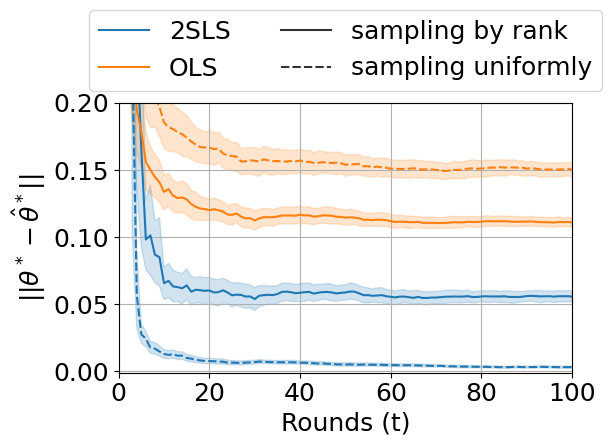

In [8]:
# converting to long format.
# df = script.runs2df(runs)
dflong = pd.melt(df, id_vars=('iterations', 'sampling'), value_vars=('ols_env0', '2sls_env0'), var_name='method', value_name='error')
dflong['method'] = dflong['method'].astype('category')
dflong['method']= dflong['method'].cat.rename_categories({'ols_env0':'OLS', '2sls_env0': '2SLS'})

dflong['iterations'] = dflong['iterations']+2
# plot
fig,ax=plt.subplots()
sns.lineplot(data=dflong, x='iterations', y='error', hue='method', style='sampling', ax=ax)
ax.set_ylim(bottom=-0.001, top=0.2)
ax.legend(loc='upper right')
ax.set_ylabel(r'$||\theta^* - \hat{\theta}^*|| $')
ax.set_xlabel('Rounds (t)')
ax.grid()
ax.set_xlim((0, 100))
handles, labels = ax.get_legend_handles_labels()
handles =  [handles[1], handles[2], handles[4], handles[5]]
labels =  [labels[1], labels[2], labels[4], labels[5]]
ax.legend(handles=handles, labels=labels, ncol=2, loc='lower center', bbox_to_anchor=(0.25, 1, .5, .5))

plt.tight_layout()
plt.savefig('figures/harris-et-al-selection-results.pdf')

In [ ]:
save_runs('experiments', 'harris-with-selection', (runs, runs2), args)

FileExistsError: [Errno 17] File exists: 'experiments/1059445/harris-with-selection'

## our setup.

In [9]:
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours --envs-accept-rate .5'

args = algos.get_args(cmd)
np.random.seed(1)
b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = data_gen.generate_data(
    args.num_applicants, args.applicants_per_round, args.fixed_effort_conversion, args
    )

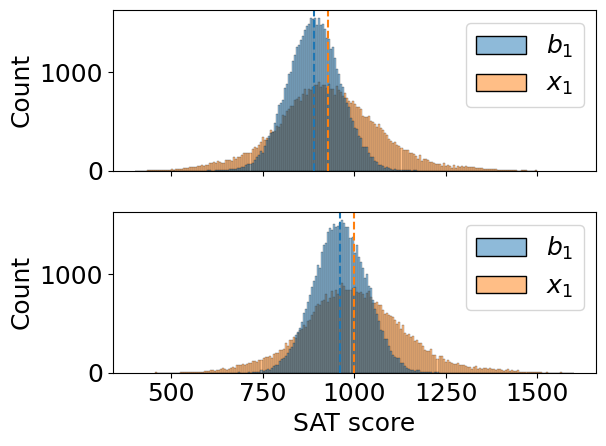

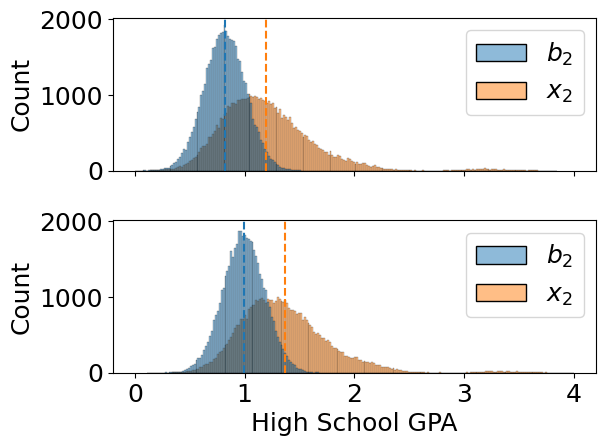

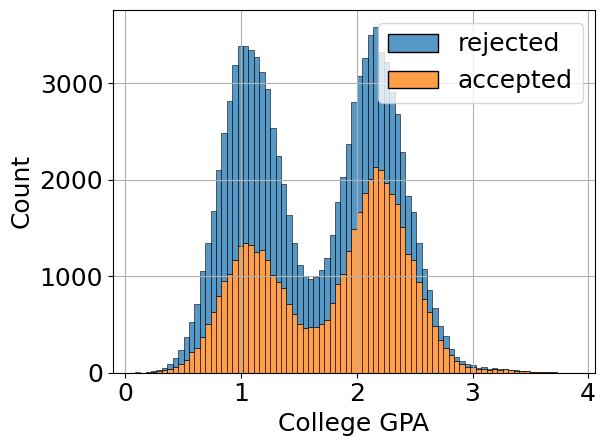

In [10]:
df0 = pd.DataFrame(
    {r'$b_1$': b[disadv_idx,0], r'$b_2$': b[disadv_idx,1], 'status': z[disadv_idx], 'y': y[0, disadv_idx],'y_hat': y_hat[0, disadv_idx],
     r'$x_1$': x[disadv_idx,0], r'$x_2$': x[disadv_idx,1]},
)
df1 = pd.DataFrame(
    {r'$b_1$': b[adv_idx,0], r'$b_2$': b[adv_idx,1], 'status': z[adv_idx], 'y': y[0, adv_idx], r'$x_1$': x[adv_idx, 0], r'$x_2$': x[adv_idx, 1], 'y_hat': y_hat[0, adv_idx]},
)
df0['class'] = 'disadv'
df1['class'] = 'adv'
df = pd.concat((df0, df1))
df['status'] = df.status.astype('category').cat.rename_categories({0.0:'rejected', 1.0: 'accepted'})
df['status']

# SAT score
dflong = pd.melt(df, id_vars=('class'), value_vars=(r'$b_1$', r'$x_1$'), var_name='time', value_name='score')
fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)

g = sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])
g.legend_.set_title(None)
g = sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])
g.legend_.set_title(None)
ax[1].set_xlabel('SAT score')

# four mean lines
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time==r'$b_1$')].score.mean(), color=sns.color_palette()[0], linestyle='--')
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time==r'$x_1$')].score.mean(), color=sns.color_palette()[1], linestyle='--')

ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time==r'$b_1$')].score.mean(), color=sns.color_palette()[0],  linestyle='--')
ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time==r'$x_1$')].score.mean(), color=sns.color_palette()[1],  linestyle='--')

plt.tight_layout()
plt.savefig('figures/our-settings-data1.png')

# GPA
dflong = pd.melt(df, id_vars=('class'), value_vars=(r'$b_2$', r'$x_2$'), var_name='time', value_name='score')
fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)
g = sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])
g.legend_.set_title(None)
g = sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])
g.legend_.set_title(None)
ax[1].set_xlabel('High School GPA')

# four mean lines
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time==r'$b_2$')].score.mean(), color=sns.color_palette()[0], linestyle='--')
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time==r'$x_2$')].score.mean(), color=sns.color_palette()[1], linestyle='--')

ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time==r'$b_2$')].score.mean(), color=sns.color_palette()[0], linestyle='--')
ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time==r'$x_2$')].score.mean(), color=sns.color_palette()[1], linestyle='--')

plt.tight_layout()
plt.savefig('figures/our-settings-data2.png')

# dfa, dfr = pd.DataFrame({'y': y[0][z==1]}), pd.DataFrame({'y': y[0][z==0]})
# df = pd.concat((dfa, dfr))
fig,ax=plt.subplots()
g = sns.histplot(df, x='y', hue='status', ax=ax, multiple='stack')
g.legend_.set_title(None)
ax.set_xlabel('College GPA')
ax.grid()

plt.tight_layout()
plt.savefig('figures/our-settings-data3.pdf')

In [11]:
n_runs =50 
args = algos.get_args(cmd)
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(algos.run_multi_env, args_list )
    # _runs = [r[2] for r in runs]
runs = [r[0] for r in runs]

99it [00:09, 10.25it/s] 
99it [00:10,  9.73it/s]
99it [00:10,  9.62it/s]
99it [00:10,  9.18it/s]
99it [00:10,  9.02it/s]
99it [00:10,  9.03it/s]
99it [00:10,  9.38it/s]
99it [00:11,  9.00it/s]
99it [00:10,  9.01it/s]
99it [00:10,  9.03it/s]
99it [00:10,  9.04it/s]
99it [00:10,  9.36it/s]
99it [00:10,  9.18it/s]
99it [00:11,  8.93it/s]
99it [00:10,  9.20it/s]
99it [00:10,  9.16it/s]

99it [00:11,  8.85it/s]
99it [00:11,  8.72it/s]
99it [00:10,  9.06it/s]
99it [00:11,  8.71it/s]
99it [00:11,  8.75it/s]
97it [00:10,  4.24it/s]
96it [00:10,  4.37it/s]
99it [00:10,  9.18it/s]
99it [00:11,  8.26it/s]
99it [00:11,  8.55it/s]
97it [00:10,  4.36it/s]
99it [00:11,  8.89it/s]
99it [00:11,  8.42it/s]
99it [00:11,  8.89it/s]
99it [00:11,  8.81it/s]
99it [00:11,  8.59it/s]
99it [00:11,  8.80it/s]
99it [00:11,  8.72it/s]
99it [00:11,  8.66it/s]
99it [00:11,  8.49it/s]
99it [00:11,  8.50it/s]
99it [00:11,  8.50it/s]
99it [00:11,  8.40it/s]
99it [00:11,  4.34it/s]
99it [00:11,  8.54it/s]
99it [00:11,  

In [12]:
df = algos.runs2df(runs)
# long format for plotting
value_vars = [f'{m}_env{e}' for m in args.methods for e in range(args.num_envs)]
dflong = pd.melt(df, id_vars='iterations', value_vars=value_vars, var_name='env', value_name='error')
dflong 
dflong['method'] = dflong.env.apply(lambda x: '_'.join(x.split('_')[:-1]))
dflong['env'] = dflong.env.apply(lambda x:x.split('_')[-1])
dflong['method'] = dflong['method'].astype('category')
dflong['method'] = dflong['method'].cat.rename_categories({'ours': 'Ours', 'ols': 'OLS', '2sls': '2SLS'})
dflong
dflong_stack = dflong # remember for later. 
dflong_stack['iterations'] = dflong_stack['iterations']+2
dflong_stack 

,iterations,env,error,method
0,2,env0,0.075612,2SLS
1,3,env0,0.014819,2SLS
2,4,env0,0.005580,2SLS
3,5,env0,0.200922,2SLS
4,6,env0,0.199418,2SLS
...,...,...,...,...
14845,96,env0,0.012292,Ours
14846,97,env0,0.012619,Ours
14847,98,env0,0.012699,Ours
14848,99,env0,0.012699,Ours


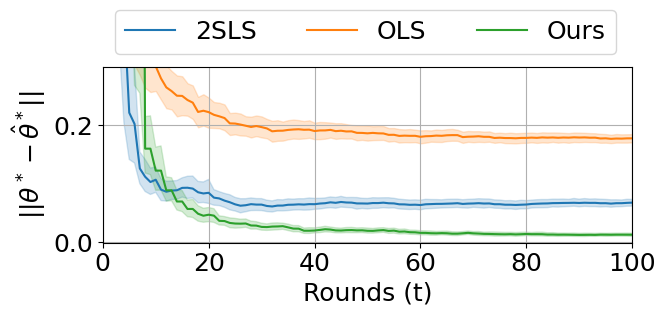

In [13]:
plt.rcParams.update({'font.size': 18})
fig,ax=plt.subplots(figsize=(7,3.5))
sns.lineplot(dflong_stack, x='iterations', y='error', errorbar=('ci', 95), ax=ax, hue='method',
             markers={'Ours': '^', 'OLS': 'X', '2SLS': 'o'}, markevery=10, markersize=9)
ax.grid()
ax.set_ylim(bottom=-0.001, top=.3)
ax.set_ylabel(r'$|| \theta^* - \hat{\theta}^* || $')
ax.set_xlabel('Rounds (t)')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:], labels=labels[:], ncol=3, loc='lower left', bbox_to_anchor=(0, 1, .5, .5))
ax.set_xlim((0, 100))
plt.tight_layout()
plt.savefig('figures/our-settings-single-env.pdf')

In [45]:
# save_runs('experiments', 'our-settings-single-env', runs, args)

In [14]:
## selection function variation. 
n_envs = 1
dfs = []
df_w = []
df_z = []
for env0_accept_rate in (.2, .4, .6, .8, 1.):
    cmd =f'--num-applicants 500000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours --offline-eval --envs-accept-rates {env0_accept_rate}'
    args = algos.get_args(cmd)

    n_runs = 10
    args_list = [(s, args) for s in np.arange(n_runs)]
    with Pool(n_runs) as p:
        runs_data = p.starmap(algos.run_multi_env, args_list )
    
    # recording errors
    runs = [r[0] for r in runs_data]
    df = algos.runs2df(runs)
    df['env0_accept_rate'] = env0_accept_rate
    dfs.append(df)
    
    # recording z
    runs_z = [r[2] for r in runs_data]
    accepted_per_round = get_accepted_per_round(runs_z, args.num_applicants / args.applicants_per_round)
    df = pd.DataFrame({'accepted_per_round': accepted_per_round, 'env0_accept_rate': env0_accept_rate})
    df['rejected_per_round'] = args.applicants_per_round - df['accepted_per_round']
    df_z.append(df)

df = pd.concat(dfs)
# df_w = pd.concat(df_w)
df_z = pd.concat(df_z)
value_vars = [f'{m}_env{ei}' for m in args.methods for ei in range(args.num_envs)]
value_vars
dflong = pd.melt(df, id_vars='env0_accept_rate', value_vars=value_vars, value_name='error', var_name='method_env')
dflong['method'] = dflong.method_env.apply(lambda x: '_'.join(x.split('_')[:-1]))
dflong['env'] = dflong.method_env.apply(lambda x:x.split('_')[-1])  


1it [00:03,  3.25s/it]
1it [00:03,  3.21s/it]
1it [00:03,  3.30s/it]
1it [00:03,  3.28s/it]
1it [00:03,  3.19s/it]
1it [00:03,  3.23s/it]
1it [00:03,  3.22s/it]
1it [00:03,  3.27s/it]
1it [00:03,  3.20s/it]
1it [00:03,  3.36s/it]
1it [00:04,  4.44s/it]
1it [00:04,  4.39s/it]
1it [00:04,  4.39s/it]
1it [00:04,  4.47s/it]
1it [00:04,  4.42s/it]
1it [00:04,  4.38s/it]
1it [00:04,  4.33s/it]
1it [00:04,  4.31s/it]
1it [00:04,  4.39s/it]
1it [00:04,  4.52s/it]
1it [00:05,  5.59s/it]
1it [00:05,  5.72s/it]
1it [00:05,  5.60s/it]
1it [00:05,  5.59s/it]
1it [00:05,  5.63s/it]
1it [00:05,  5.61s/it]
1it [00:05,  5.55s/it]
1it [00:05,  5.50s/it]

1it [00:05,  5.62s/it]
1it [00:06,  6.75s/it]
1it [00:06,  6.75s/it]
1it [00:06,  6.68s/it]
1it [00:06,  6.65s/it]
1it [00:06,  6.67s/it]
1it [00:06,  6.79s/it]

1it [00:06,  6.67s/it]
1it [00:06,  6.91s/it]
1it [00:06,  6.98s/it]
1it [00:07,  7.96s/it]
1it [00:07,  7.94s/it]
1it [00:07,  7.95s/it]
1it [00:07,  7.89s/it]
1it [00:07,  7.89s/it]
1it [00:0

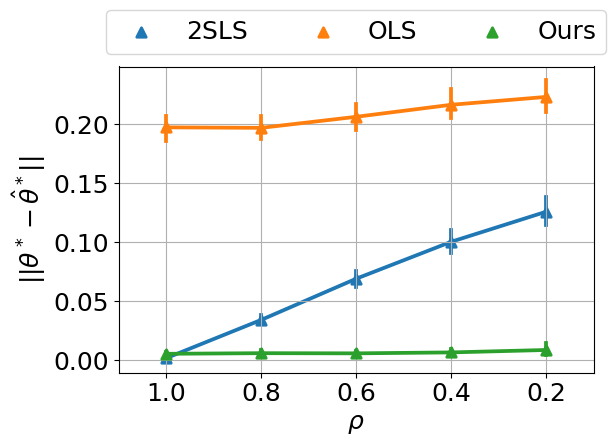

In [15]:
dflong
fig,ax=plt.subplots() 
dflong['method'] = dflong['method'].astype('category')
dflong['method'] = dflong['method'].cat.rename_categories({'2sls': '2SLS', 'ols': 'OLS', 'ours': 'Ours'})
sns.pointplot(data=dflong[dflong.env=='env0'], x='env0_accept_rate', y='error', hue='method', markers='^')
ax.grid() 

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:], labels=labels[:], ncol=3, loc='lower center', bbox_to_anchor=(0.5, 1))

ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$|| \theta^* - \hat{\theta}^*|| $')
plt.tight_layout()
ax.invert_xaxis () 
plt.savefig('figures/our-setttings-single-env-ablation.pdf')

In [16]:
# save_runs('experiments', 'our-settings-single-env-ablation', dflong, args)

## our setup (multiple envs.)

In [17]:
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods ours --num-envs 2 --theta-star-std 0 --envs-accept-rate .5 .5 --num-cooperative-envs 2'
args = algos.get_args(cmd)
np.random.seed(3)
b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = data_gen.generate_data(
    args.num_applicants, args.applicants_per_round, args.fixed_effort_conversion, args
    )

1.6502210708204164
1.716850435185807
1.8170594956638126


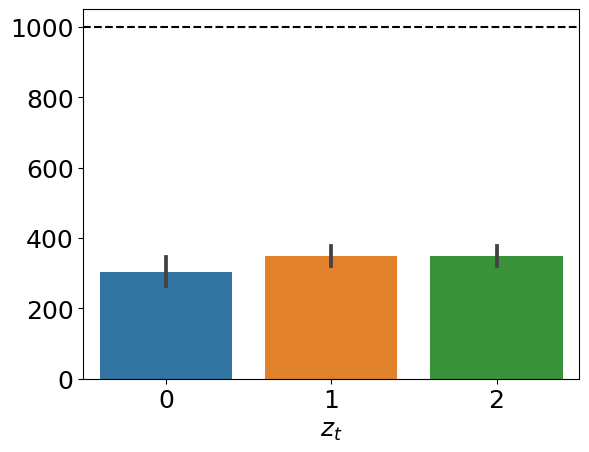

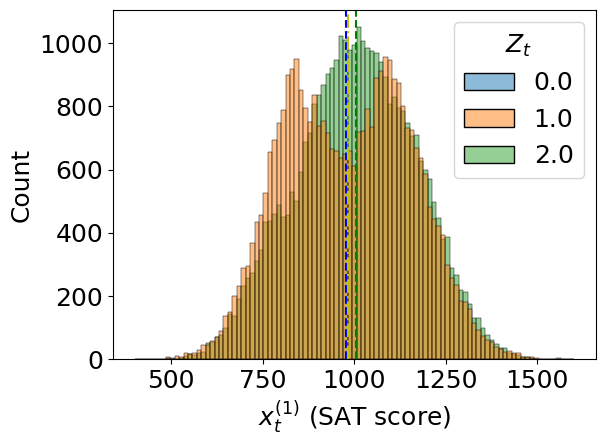

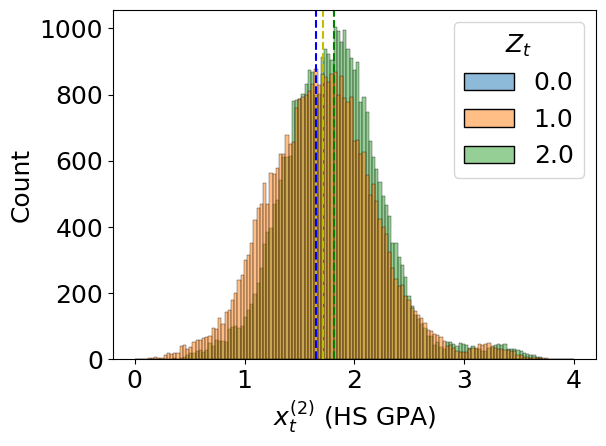

In [18]:

def add_envs(d, idx, var, prefix): 
    d.update({
        f'{prefix}_env{env_idx}': var[env_idx, idx] for env_idx in range(args.num_envs)
    })
    return d

# disadvantage class
df0 = {'b1': b[disadv_idx,0], 'b2': b[disadv_idx,1], 'status': z[disadv_idx], 'y': y[0, disadv_idx],'y_hat': y_hat[0, disadv_idx],
     'x1': x[disadv_idx,0], 'x2': x[disadv_idx,1]}
df0 = add_envs(df0, disadv_idx, y, 'y')
df0 = add_envs(df0, disadv_idx, w, 'w')
df0.keys() 

df0 = pd.DataFrame(df0)
df0['class'] = 'disadv'

# advantaged class
df1 = {'b1': b[adv_idx,0], 'b2': b[adv_idx,1], 'status': z[adv_idx], 'y': y[0, adv_idx],'y_hat': y_hat[0, adv_idx],
     'x1': x[adv_idx,0], 'x2': x[adv_idx,1]}
df1 = add_envs(df1, adv_idx, y, 'y')
df1 = add_envs(df1, adv_idx, w, 'w')
df1.keys() 

df1 = pd.DataFrame(df1)
df1['class'] = 'adv'
df = pd.concat((df0, df1))
df['status'] = df['status'].astype('category')
df
fig,ax=plt.subplots()

# first plot
df_z = pd.get_dummies(df['status'] ).to_numpy()
df_z = np.array(
  np.split(
    df_z, (args.num_applicants / args.applicants_per_round),  axis=0 
  )
)
ax.axhline(y=args.applicants_per_round, color='k', linestyle='--')

assert df_z.shape == ((args.num_applicants / args.applicants_per_round), args.applicants_per_round, args.num_envs+1), f"{df_z.shape}"
df_z = df_z.sum(axis=1) 
sns.barplot(pd.DataFrame(df_z), ax=ax)
ax.set_xlabel(r'$z_t$')

# second plot
fig,ax=plt.subplots()
df = df.rename(columns={'status': r'$Z_t$'})
# df[r'$Z_t$'] = df[r'$Z_t$'].cat.rename_categories({0.0: '0', 1.0: '1', 2.0: '2'})

sns.histplot(df[df[r'$Z_t$']!=0], x='x1', hue=r'$Z_t$', ax=ax)
ax.axvline(x=df[df[r'$Z_t$']==0].x1.mean(), color='b', linestyle='--')
ax.axvline(x=df[df[r'$Z_t$']==1].x1.mean(), color='y', linestyle='-.')
ax.axvline(x=df[df[r'$Z_t$']==2].x1.mean(), color='g', linestyle='--')
ax.axvline(x=df[df[r'$Z_t$']==3].x1.mean(), color='r', linestyle='--')
ax.set_xlabel(r'$x_t^{(1)}$ (SAT score)')

plt.tight_layout()
plt.savefig('figures/our-settings-multi1.png')

# third plot
fig,ax=plt.subplots()
sns.histplot(df[df[r'$Z_t$']!=0], x='x2', hue=r'$Z_t$', ax=ax)
for env_idx, c  in zip(range(args.num_envs+1), ('b', 'y', 'g', 'r')):
  print(df[df[r'$Z_t$']==env_idx].x2.mean())
  ax.axvline(x=df[df[r'$Z_t$']==env_idx].x2.mean(), c=c, linestyle='--')

ax.set_xlabel(r'$x_t^{(2)}$ (HS GPA)')
plt.tight_layout() 
plt.savefig('figures/our-settings-multi2.png')

## protocol vs. no protocol.

In [19]:
_runs = []
for nce  in tqdm.tqdm((2, 1)):
    cmd = f'--num-applicants 300000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods ours --num-envs 2 --theta-star-std 0 --envs-accept-rates .5 --num-cooperative-envs {nce}'
    # print(cmd)
    
    args = algos.get_args(cmd)
    n_runs = 50
    args_list = [(s, args) for s in np.arange(n_runs)]
    with Pool(n_runs) as p:
        runs = p.starmap(algos.run_multi_env, args_list )
    _runs.append(runs)

  0%|          | 0/2 [00:00<?, ?it/s]

99it [00:06, 14.35it/s]
99it [00:06, 14.25it/s]
99it [00:06, 14.50it/s]
99it [00:06, 14.29it/s]
99it [00:07, 12.42it/s]
99it [00:07, 14.02it/s]
99it [00:07, 12.83it/s]
99it [00:07, 13.74it/s]
99it [00:07, 14.08it/s]
99it [00:07, 13.82it/s]
99it [00:06, 14.42it/s]
99it [00:07, 13.62it/s]
99it [00:06, 14.31it/s]
99it [00:07, 13.90it/s]
99it [00:06, 14.30it/s]
99it [00:07, 14.10it/s]
99it [00:07, 14.10it/s]
99it [00:06, 14.29it/s]
99it [00:07, 13.91it/s]
99it [00:07, 12.87it/s]
99it [00:07, 13.16it/s]
99it [00:07, 13.76it/s]
99it [00:07, 13.86it/s]
99it [00:07, 14.04it/s]
99it [00:08, 12.21it/s]
99it [00:07, 13.73it/s]
99it [00:07, 13.75it/s]
99it [00:07, 13.81it/s]
99it [00:07, 13.49it/s]
99it [00:07, 13.90it/s]
99it [00:07, 13.75it/s]
99it [00:07, 13.78it/s]
99it [00:07, 13.72it/s]
99it [00:07, 13.54it/s]
99it [00:07, 13.57it/s]
99it [00:07, 13.33it/s]
99it [00:07, 13.47it/s]
99it [00:07, 12.43it/s]
99it [00:07, 12.85it/s]
99it [00:08, 11.77it/s]
99it [00:07, 13.63it/s]
99it [00:07, 13.

In [20]:
runs_protocol = _runs[0 ]
runs_no_protocol = _runs[1 ]

def get_data(runs_protocol, env_idx):
    dfs = []
    for r in runs_protocol:
        r = r[1][f'ours_env{env_idx}']
        arr = np.array(r)
        dfs.append(pd.DataFrame(arr))
    df = pd.concat(dfs )
    df.reset_index(inplace=True);
    df.rename({'index': 'iterations'}, axis=1, inplace=True)
    df
    return df

dfs = []
for env_idx in (0, 1):
  df = get_data(runs_protocol, env_idx) 
  df2 = get_data(runs_no_protocol, env_idx)
  df['is-protocol'] = 'Co-op'
  df2['is-protocol'] = 'No co-op.'
  df = pd.concat((df, df2))
  df['env'] = env_idx
  dfs.append(df) 

df = pd.concat(dfs)
df.reset_index(inplace=True)
df 

,index,iterations,0,1,is-protocol,env
0,0,0,NaN,NaN,Co-op,0
1,1,1,NaN,NaN,Co-op,0
2,2,2,0.003199,0.000018,Co-op,0
3,3,3,0.003199,0.000018,Co-op,0
4,4,4,0.000496,0.474591,Co-op,0
...,...,...,...,...,...,...
19795,4945,94,-0.000137,0.506742,No co-op.,1
19796,4946,95,-0.000137,0.506742,No co-op.,1
19797,4947,96,-0.000140,0.508337,No co-op.,1
19798,4948,97,-0.000131,0.504676,No co-op.,1


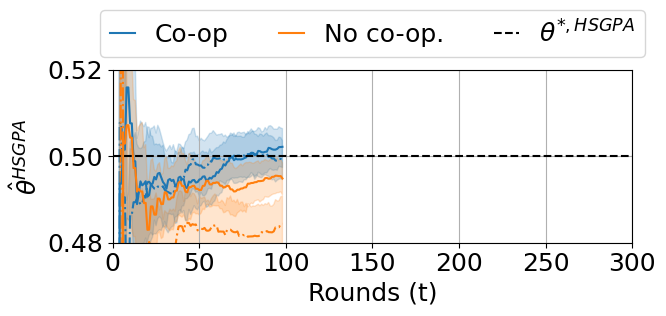

In [21]:
fig,ax=plt.subplots(figsize=(7,3.5))
sns.lineplot(df[df.env==1], x='iterations', y=1, hue='is-protocol', linestyle='dashdot', legend=False)
sns.lineplot(df[df.env==0], x='iterations', y=1, hue='is-protocol')
ax.set_ylim((0.48, 0.52))
ax.axhline(y=0.5, color='k', linestyle='--', label=r'$\theta^{*, HS GPA}$')
ax.set_ylabel(r'$\hat{\theta}^{HS GPA}$')
ax.set_xlabel(r'Rounds (t)')
ax.grid() 

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles=handles[:], labels=labels[:], ncol=3, loc='lower center', bbox_to_anchor=(0.5, 1), handlelength=1, labelspacing =0)

ax.set_xlim((0, 300))
plt.tight_layout()
plt.savefig('figures/protocol-vs-no-protocol.pdf')

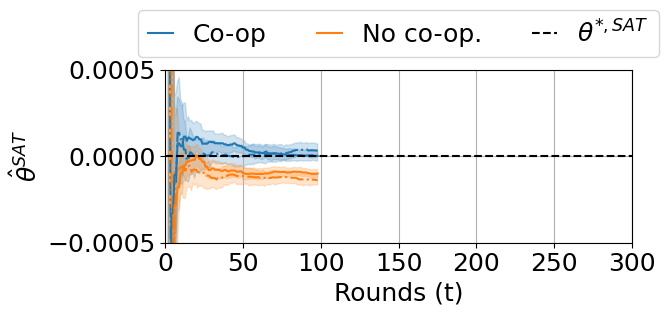

In [22]:
fig,ax=plt.subplots(figsize=(7,3.5))
sns.lineplot(df[df.env==1], x='iterations', y=0, hue='is-protocol', linestyle='dashdot', legend=False, errorbar=('ci', 99))
sns.lineplot(df[df.env==0], x='iterations', y=0, hue='is-protocol')
ax.set_ylim((-0.0005, 0.0005))
ax.axhline(y=0, color='k', linestyle='--', label=r'$\theta^{*, SAT}$')
ax.set_ylabel(r'$\hat{\theta}^{SAT}$')
ax.set_xlabel(r'Rounds (t)')
ax.grid() 

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles=handles[:], labels=labels[:], ncol=3, loc='lower center', bbox_to_anchor=(0.5, 1), handlelength=1, labelspacing =0)

ax.set_xlim((0, 300))
plt.tight_layout()
plt.savefig('figures/protocol-vs-no-protocol2.pdf')

## protocol improvement 

In [23]:
_runs = []
n_envs = 3
coop_envs = (3, 2)
for nce  in tqdm.tqdm(coop_envs):
    cmd = f'--offline-eval --num-applicants 500000 --applicants-per-round 5000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods ours --num-envs {n_envs} --theta-star-std .1 --envs-accept-rates .5 --num-cooperative-envs {nce}'
    # print(cmd)
    
    args = algos.get_args(cmd)
    n_runs = 100  
    args_list = [(s, args) for s in np.arange(n_runs)]
    with Pool(n_runs) as p:
        runs = p.starmap(algos.run_multi_env, args_list )
        _runs.append(runs)

  0%|          | 0/2 [00:00<?, ?it/s]

1it [00:01,  1.66s/it]
1it [00:01,  1.64s/it]
1it [00:01,  1.56s/it]
1it [00:01,  1.83s/it]
1it [00:01,  1.54s/it]
1it [00:02,  2.25s/it]
1it [00:02,  2.18s/it]
1it [00:02,  2.17s/it]
1it [00:01,  1.91s/it]
1it [00:01,  1.77s/it]
1it [00:02,  2.05s/it]
1it [00:01,  1.58s/it]
1it [00:01,  1.20s/it]
1it [00:01,  1.15s/it]
1it [00:01,  1.63s/it]
1it [00:02,  2.47s/it]
1it [00:01,  1.88s/it]
1it [00:01,  1.41s/it]
1it [00:02,  2.71s/it]
1it [00:01,  1.75s/it]
1it [00:01,  1.61s/it]
1it [00:02,  2.11s/it]
1it [00:01,  1.33s/it]
1it [00:01,  1.70s/it]
1it [00:01,  1.77s/it]
1it [00:02,  2.39s/it]
1it [00:01,  1.42s/it]
1it [00:01,  1.06s/it]
1it [00:00,  1.57it/s]
1it [00:01,  1.99s/it]
1it [00:01,  1.21s/it]
1it [00:01,  1.23s/it]
1it [00:01,  1.21s/it]
1it [00:01,  1.46s/it]
1it [00:01,  1.13s/it]
1it [00:01,  1.39s/it]
1it [00:01,  1.09s/it]
1it [00:01,  1.33s/it]
1it [00:00,  1.06it/s]
1it [00:00,  1.11it/s]
1it [00:01,  1.10s/it]
1it [00:01,  1.08s/it]
1it [00:01,  1.50s/it]
1it [00:01,

In [24]:
dfs = []
for i, nce in enumerate((coop_envs)):
  df = algos.runs2df([r[0] for r in _runs[i]])
  df['cooperative envs.'] = r'Full Cooperation' if nce == 3 else r'Partial Cooperation'
  dfs.append(df)

df = pd.concat(dfs)
df['ours_env0+ours_env1'] = (df['ours_env0'] + df['ours_env1']) / 2.
df 

,iterations,ours_env0,ours_env1,ours_env2,cooperative envs.,ours_env0+ours_env1
0,0,0.003477,0.004488,0.006263,Full Cooperation,0.003982
1,0,0.012031,0.006962,0.000964,Full Cooperation,0.009497
2,0,0.013893,0.000433,0.001759,Full Cooperation,0.007163
3,0,0.004807,0.003717,0.007752,Full Cooperation,0.004262
4,0,0.001008,0.014227,0.003051,Full Cooperation,0.007618
...,...,...,...,...,...,...
95,0,0.002004,0.002251,0.007066,Partial Cooperation,0.002127
96,0,0.006560,0.010345,0.010648,Partial Cooperation,0.008452
97,0,0.014004,0.013472,0.020794,Partial Cooperation,0.013738
98,0,0.016225,0.016918,0.015263,Partial Cooperation,0.016571


In [25]:
value_vars= (f'ours_env{i}' for i in range(args.num_envs))
dflong = pd.melt(df, id_vars=('iterations', 'cooperative envs.'), value_vars=value_vars, var_name='env', value_name='error' )
dflong 

rename_cats_args = {f'ours_env{env_idx}': f'${env_idx+1}$' for env_idx in range(args.num_envs)}
dflong['env']=dflong.env.astype('category').cat.rename_categories(rename_cats_args)
dflong 

,iterations,cooperative envs.,env,error
0,0,Full Cooperation,$1$,0.003477
1,0,Full Cooperation,$1$,0.012031
2,0,Full Cooperation,$1$,0.013893
3,0,Full Cooperation,$1$,0.004807
4,0,Full Cooperation,$1$,0.001008
...,...,...,...,...
595,0,Partial Cooperation,$3$,0.007066
596,0,Partial Cooperation,$3$,0.010648
597,0,Partial Cooperation,$3$,0.020794
598,0,Partial Cooperation,$3$,0.015263


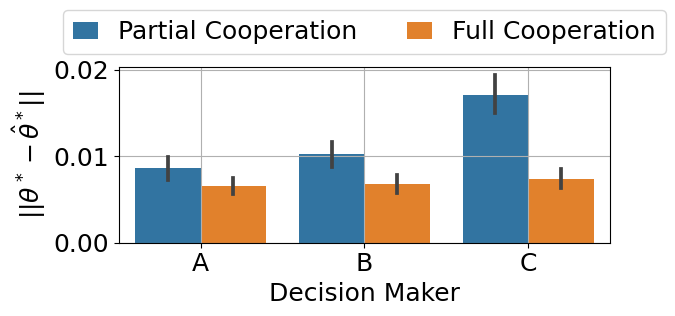

In [26]:
fig,ax=plt.subplots(figsize=(7,3.5))
sns.barplot(dflong, x='env', hue='cooperative envs.', y='error', 
            palette={'Full Cooperation': sns.color_palette()[1], 'Partial Cooperation': sns.color_palette()[0]},
            hue_order=('Partial Cooperation', 'Full Cooperation'))
# ax.legend(bbox_to_anchor=(1,1), title='cooperative envs.')
ax.grid() 
ax.set_ylabel(r'$|| \theta^* - \hat{\theta}^*||$')
ax.set_xlabel('Decision Maker')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:], labels=labels[:], ncol=2, loc='lower center', bbox_to_anchor=(0.5, 1), handlelength=1, labelspacing =0)
ax.set_xticklabels(('A', 'B', 'C'))

plt.tight_layout()
plt.savefig('figures/protocol-vs-no-protocol-group.pdf')

In [61]:
save_runs('experiments', 'protocol-vs-no-protocol-group', dflong, args)

# utility experiments

In [6]:
import numpy as np
from py.utils import recover_thetas
from py.data_gen import run_simulator, generate_data
cmd = ('--num-applicants 500000 --applicants-per-round 1000 --scaled-duplicates sequence '
       '--fixed-effort-conversion --normalize --methods ours ols --num-envs 2 --theta-star-std 0 '
       '--envs-accept-rates .5 --num-cooperative-envs 2')
cmd = f'{cmd} --offline-eval'
args =algos.get_args(cmd)
seed=1
test_theta_envs = ('theta_star_hat', 'theta_ols_hat')

def run_multi_env_utility2(args, seed, test_theta_envs):
    np.random.seed(seed)
    _, x, y, _, theta, _, z, _, _, _, _, theta_star, pref_vect = generate_data(
    args.num_applicants, args.applicants_per_round, args.fixed_effort_conversion, 
                args, fixed_competitors=True)

    test_thetas = np.zeros(shape=(args.num_envs, 2))

    # estimating causal params.
    err_list, est_list = {}, {}
    envs_itr = range(args.num_envs)
    for env_idx in envs_itr:
        dictenv_err, dictenv_est = algos.run_single_env(
        args, x, y, theta, z, theta_star, env_idx, pref_vect
        )
        for k, v in dictenv_err.items():
            err_list[f'{k}_env{env_idx}'] = v
        for k, v in dictenv_est.items():
            est_list[f'{k}_env{env_idx}'] = v

    # replacing the estimate of causal parameter of fixed competitors with the ground truth one.
    for env_idx in range(1, args.num_envs):
       est_list[f'ours_env{env_idx}'] = [theta_star[env_idx]]
       err_list[f'ours_env{env_idx}'] = 0

    # recovering test thetas. 
    for env_idx in envs_itr:
        test_thetas[env_idx] = recover_thetas(
        args.num_applicants, args.applicants_per_round, 
        y, theta, z, env_idx, est_list, test_theta_envs[env_idx]
    )
    test_thetas = test_thetas[np.newaxis]

    # generating test data.
    args.num_applicants = args.applicants_per_round # only one round.
    _, _, _, _, _, y_test,_, _ ,z_test,_, _ = run_simulator(
    args.applicants_per_round, args.fixed_effort_conversion, args, theta_star, test_thetas
    )
    y_test = y_test.T

    # compute utilities 
    utilities = np.zeros((args.num_envs,))
    for env_idx in range(args.num_envs):
        utilities[env_idx] = y_test[:,  env_idx][z_test==(env_idx+1)].mean()
    return utilities

run_multi_env_utility2(args, seed, test_theta_envs)

1it [00:03,  3.62s/it]
1it [00:00,  5.66it/s]


array([2.54048617, 2.49772625])

1it [00:00,  3.94it/s]
1it [00:00,  2.41it/s]
1it [00:00,  1.95it/s]
1it [00:00,  1.38it/s]
1it [00:00,  1.27it/s]
1it [00:00,  1.11it/s]
1it [00:00,  1.39it/s]
1it [00:00,  1.12it/s]
1it [00:00,  1.11it/s]
1it [00:00,  1.13it/s]
1it [00:00,  1.15it/s]
1it [00:00,  1.00it/s]
1it [00:00,  1.50it/s]
1it [00:00,  2.05it/s]
1it [00:00,  1.96it/s]
1it [00:00,  2.12it/s]
1it [00:00,  2.57it/s]
1it [00:00,  1.39it/s]
1it [00:00,  1.15it/s]
1it [00:01,  1.20s/it]
1it [00:00,  1.04it/s]
1it [00:01,  1.12s/it]
1it [00:01,  1.06s/it]
1it [00:00,  1.59it/s]
1it [00:00,  1.71it/s]
1it [00:00,  1.37it/s]
1it [00:01,  1.17s/it]
1it [00:01,  1.21s/it]
1it [00:00,  1.65it/s]
1it [00:00,  1.44it/s]
1it [00:01,  1.01s/it]
1it [00:00,  1.34it/s]
1it [00:00,  1.64it/s]
1it [00:00,  1.58it/s]
1it [00:01,  1.20s/it]
1it [00:00,  1.12it/s]
1it [00:00,  1.04it/s]
1it [00:00,  1.29it/s]
1it [00:00,  1.14it/s]
1it [00:00,  1.22it/s]
1it [00:00,  1.38it/s]
1it [00:00,  1.15it/s]
1it [00:00,  1.10it/s]
1it [00:00,

perf_env0          
                     mean       sem
test_theta_env0                    
theta_ao_hat     2.837195  0.007925
theta_ols_hat    2.803878  0.008008
theta_star_hat   2.803440  0.008006

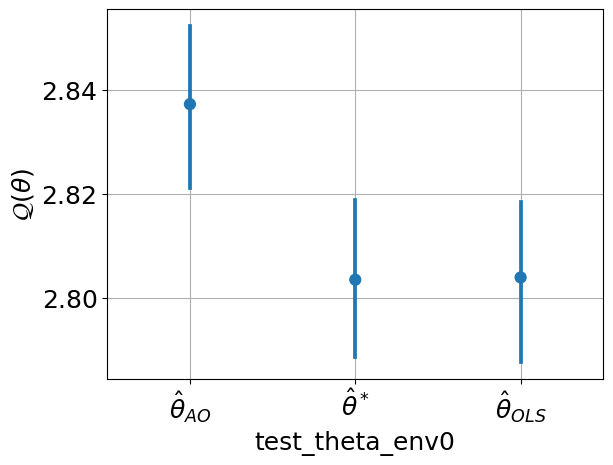

In [7]:
cmd =(f'--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence '
       '--fixed-effort-conversion --normalize --methods ols ours --envs-accept-rate .25')
cmd = f'{cmd} --offline-eval'

args = algos.get_args(cmd)
# one environment.
combos = [
    ('theta_ao_hat', ),
    ('theta_star_hat', ),
    ('theta_ols_hat', )
]

dfs = []
for combo in combos:
    n_runs = 100
    args_list = [(args, t, combo) for t in range(n_runs)]
    with Pool(n_runs) as p:
        results = p.starmap(run_multi_env_utility2, args_list)

    results = np.array(results)
    pd_dict = {f'perf_env{env_idx}': results[:, env_idx] for env_idx in range(args.num_envs)}
    pd_dict.update(
        {f'test_theta_env{env_idx}': combo[env_idx] for env_idx in range(args.num_envs) }
    )
    df = pd.DataFrame(data=pd_dict)
    dfs.append(df )

df = pd.concat(dfs)
fig,ax=plt.subplots()
sns.pointplot(df, y='perf_env0', x='test_theta_env0', join=False)
ax.set_ylabel(r'$\mathcal{Q}(\theta)$')
ax.set_xticklabels(labels=[r'$\hat{\theta}_{AO}$', r'$\hat{\theta}^*$', r'$\hat{\theta}_{OLS}$'])
ax.grid() 

df_test = df.groupby('test_theta_env0').agg(('mean', 'sem'))
df_test 

In [9]:
# with open('temp.pkl', 'wb') as f:
    # pickle.dump(df_test, f)
with open('temp.pkl', 'rb') as f:
    ref =pickle.load(f)

ref == df_test 

perf_env0      
                     mean   sem
test_theta_env0                
theta_ao_hat         True  True
theta_ols_hat        True  True
theta_star_hat       True  True

# utility exps. (multiple envs.)

In [4]:
from itertools import  product
combos = [x for x in product(
    ('theta_ao_hat', 'theta_ols_hat', 'theta_star_hat'),
    ('theta_ols_hat', 'theta_ols_hat', 'theta_star_hat'),
)]
cmd = ('--num-applicants 500000 --applicants-per-round 1000 --scaled-duplicates sequence '
       '--fixed-effort-conversion --normalize --methods ours ols --num-envs 2 --theta-star-std 0 '
       '--envs-accept-rates .5 --num-cooperative-envs 2')
cmd = f'{cmd} --offline-eval'
args =algos.get_args(cmd)

combos = [x for x in product(
    ('theta_ao_hat', 'theta_ols_hat', 'theta_star_hat'),
    ('theta_ao_hat', 'theta_ols_hat', 'theta_star_hat'),
)]

dfs = []
for combo in tqdm.tqdm(combos):
    n_runs = 100 
    args_list = [(args, t, combo) for t in range(n_runs)]
    with Pool(n_runs) as p:
        results = p.starmap(run_multi_env_utility2, args_list)

    results = np.array(results)
    pd_dict = {f'perf_env{env_idx}': results[:, env_idx] for env_idx in range(args.num_envs)}
    pd_dict.update(
        {f'test_theta_env{env_idx}': combo[env_idx] for env_idx in range(args.num_envs) }
    )
    df = pd.DataFrame(data=pd_dict)
    dfs.append(df )

df = pd.concat(dfs)

  0%|          | 0/9 [00:00<?, ?it/s]

1it [00:05,  5.57s/it]
1it [00:00,  4.74it/s]
1it [00:05,  5.50s/it]
1it [00:05,  5.41s/it]
1it [00:00,  4.39it/s]
1it [00:05,  5.73s/it]
1it [00:05,  5.66s/it]
1it [00:05,  5.57s/it]
1it [00:05,  5.51s/it]
1it [00:05,  5.40s/it]
1it [00:05,  5.38s/it]
1it [00:05,  5.41s/it]
1it [00:00,  4.65it/s]
1it [00:00,  4.32it/s]
1it [00:00,  4.68it/s]
1it [00:00,  4.58it/s]
1it [00:00,  4.83it/s]
1it [00:05,  5.27s/it]
1it [00:05,  5.47s/it]
1it [00:05,  5.34s/it]
1it [00:05,  5.54s/it]
1it [00:00,  4.73it/s]
1it [00:05,  5.49s/it]
1it [00:05,  5.41s/it]
1it [00:05,  5.24s/it]
1it [00:05,  5.66s/it]
1it [00:00,  4.29it/s]
1it [00:05,  5.14s/it]
1it [00:04,  4.94s/it]
1it [00:00,  4.78it/s]
1it [00:05,  5.50s/it]
1it [00:05,  5.38s/it]
1it [00:05,  5.48s/it]
1it [00:05,  5.41s/it]
1it [00:05,  5.14s/it]
1it [00:00,  4.76it/s]
1it [00:00,  4.61it/s]
1it [00:05,  5.30s/it]
1it [00:05,  5.20s/it]
1it [00:00,  4.59it/s]
1it [00:00,  4.63it/s]
1it [00:00,  4.79it/s]
1it [00:05,  5.07s/it]
1it [00:04,

/home/maadil/anaconda3/envs/strategic-iv/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


perf_env0          
                                           mean       sem
$\theta_{2t}$         test_theta_env0                    
$\hat{\theta}^{AO}_2$ theta_ao_hat     2.554082  0.009728
                      theta_ols_hat    2.531033  0.010351
                      theta_star_hat   2.531856  0.010459
$\hat{\theta}_{OLS}$  theta_ao_hat     2.628063  0.007140
                      theta_ols_hat    2.608500  0.006792
                      theta_star_hat   2.607939  0.006889
$\hat{\theta}^*_2$    theta_ao_hat     2.626404  0.007156
                      theta_ols_hat    2.608517  0.006943
                      theta_star_hat   2.606868  0.006729

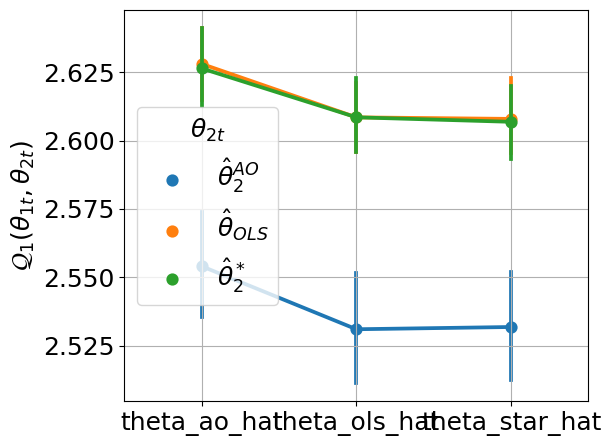

In [5]:
df['test_theta_env0'] = df['test_theta_env0'].astype('category')
df['test_theta_env1'] = df['test_theta_env1'].astype('category')
pd.melt(df, id_vars='perf_env0', value_vars=('test_theta_env0', 'test_theta_env1'))
df 
df_ = df[['perf_env0', 'test_theta_env0', 'test_theta_env1']]

df_['test_theta_env1'] = df_['test_theta_env1'].cat.rename_categories(
    {
        'theta_ao_hat': r'$\hat{\theta}^{AO}_2$',
        'theta_star_hat': r'$\hat{\theta}^*_2$',
        'theta_ols_hat': r'$\hat{\theta}_{OLS}$'
        }
)
df_ = df_.rename(columns={'test_theta_env1': r'$\theta_{2t}$'})
df_ 

fig,ax=plt.subplots() 
plot_obj = sns.pointplot(df_, y='perf_env0', x='test_theta_env0', hue=r'$\theta_{2t}$', ax=ax)
ax.grid () 

ax.set_ylabel(r'$\mathcal{Q}_1(\theta_{1t}, \theta_{2t})$')
ax.set_xlabel('')
# ax.set_xticklabels([r'$\theta_{1t} = \hat{\theta}^{AO}_1$', r'$\theta_{1t} = \hat{\theta}^*_1$'])

plt.tight_layout() 
plt.savefig('figures/utility-multi-env.pdf')
df_test = df_.groupby([r'$\theta_{2t}$', 'test_theta_env0' ]).agg(['mean', 'sem'])
df_test 